# Pneumonia Classification in Chest X-rays using Transfer Learning <br> (ResNet-18)
In recent years, increasing the depth of neural networks has proven crucial for enhancing their learning capacity and performance in complex tasks, such as image recognition. However, training increasingly deep networks poses significant technical challenges, particularly related to the propagation of information and gradients during training.

Kaiming He and collaborators stated: "Driven by the significance of depth, a question arises: Is
learning better networks as easy as stacking more layers?" 

This question is precisely what ResNet addresses, a convolutional neural network (CNN) architecture whose name indicates the number of layers in the architecture. Introduced in 2015 by Microsoft, ResNet offered a solution to the vanishing gradient problem that occurred when adding extra layers, through the use of **skip connections**. The ResNet family includes models of various depths, such as ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, each adapted to different levels of complexity and learning capacity.

You can find more details in the original [ResNet paper](https://arxiv.org/abs/1512.03385)

### 1. Library Imports for Transfer Learning

For the implementation of the second model, the core PyTorch libraries were utilized. Specifically, the models sub-module from torchvision was imported to access the ResNet18 architecture and its pre-trained weights. Additionally, seaborn was included to enhance the visualization of the final comparison metrics.

In [1]:
# Core deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models # Crucial for Transfer Learning

# Data handling and processing
import numpy as np
from torchvision import datasets, transforms

# Visualization and Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# System and environment configuration
import os
os.environ['MallocStackLogging'] = '0'
import sys
import os

# Aesthetic settings for high-quality plots in GitHub
plt.style.use('seaborn-v0_8-muted') 
plt.rcParams['figure.figsize'] = (12, 6) # anteriormente tenia 10,6


# esto tengo que componerlo:
# Configuración de rutas
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data.dataloaders import get_loaders



### 2. Data Loading and Preprocessing

The system paths were configured to access local modules and the dataloaders were initialized. An image size of 228x228 was selected to balance detail and computational cost.

In [2]:
# Execute the function to get data loaders
# batch_size=32 is a stable standard for training
train_loader, test_loader = get_loaders(
    batch_size=32,
    model_type="resnet"
    )

print(f"train_loader variable defined: {train_loader is not None}")


Dataset Configuration: RESNET
Train samples: 5216
Test samples:  624
Classes:       ['NORMAL', 'PNEUMONIA']
Class distribution (train):
  - NORMAL: 1341 (25.7%)
  - PNEUMONIA: 3875 (74.3%)
⚠️  Dataset desbalanceado detectado. Considera usar:
   - Weighted CrossEntropyLoss
   - Focal Loss
   - SMOTE o oversampling

ℹ️  Detectado Apple Silicon. Reduciendo num_workers a 0 para evitar problemas.
train_loader variable defined: True


### 3. ResNet18 Implementation and Customization

The ResNet18 architecture was adapted to serve as the primary model. Since the original model was trained on the ImageNet dataset (RGB images), the input layer was modified to process single-channel grayscale X-rays. Furthermore, the weights of the convolutional base were frozen to prevent their distortion during the initial training phase.

In [ ]:
# Crear modelo ResNet18 con Transfer Learning
def create_resnet_model(num_classes=2, dropout=0.5):
    """
    Crea ResNet18 pre-entrenado con clasificador personalizado
    """
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    
    # FASE 1: Congelar todas las capas convolucionales
    for param in model.parameters():
        param.requires_grad = False
    
    # Reemplazar clasificador final
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.BatchNorm1d(256),  # Ayuda con datasets pequeños
        nn.Linear(256, num_classes)
    )
    
    return model

# Selección de dispositivo
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Training on: CPU")

model = create_resnet_model(dropout=0.5).to(device)
print("✓ Modelo ResNet18 creado y migrado a dispositivo")

Training on: Apple Silicon GPU (MPS)
✓ Modelo ResNet18 creado y migrado a dispositivo


### 4. Training Loop Definition

A function was created to manage the training process, error calculation, and weight optimization.

In [4]:

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10, patience=3):

    """
    The training loop was implemented to optimize the model parameters 
    and evaluate performance on the test set.
    """
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    # INITIALIZATION FOR EARLY STOPPING
    best_loss = float('inf')
    epochs_no_improve = 0


    for epoch in range(epochs):
        # --- TRAINING PHASE ---
            model.train()
            running_loss, correct_train, total_train = 0.0, 0, 0
            
            print(f"\n--- Epoch {epoch+1}/{epochs} ---")
            
            for images, labels in train_loader:
                # Data was moved to the selected device (MPS/CUDA/CPU)
                images, labels = images.to(device), labels.to(device)
                
                # Gradients were reset
                optimizer.zero_grad()
                
                # Forward pass: Predictions were generated
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass: Gradients were calculated and weights updated
                loss.backward()
                optimizer.step()
                
                # Training metrics were accumulated
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct_train / total_train
            
            # --- EVALUATION PHASE ---
            model.eval()
            test_loss, correct_test, total_test = 0.0, 0, 0
            
            # Gradient calculation was disabled for evaluation to save memory
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()
            
            val_loss = test_loss / len(test_loader)
            val_acc = 100 * correct_test / total_test
            
            # Epoch metrics were stored in history
            history['train_loss'].append(epoch_loss)
            history['test_loss'].append(val_loss)
            history['train_acc'].append(epoch_acc)
            history['test_acc'].append(val_acc)
            
            print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
            print(f"Test  Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

            # Save the best model based on test loss with early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), "best_model.pth")
                print("Best model saved")
            else:
                epochs_no_improve += 1
                print(f"No improvement ({epochs_no_improve}/{patience})")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered")
                    break
            
    return history



### 5. Model Training Strategy: Two-Stage Transfer Learning
To achieve the best performance on our X-ray classification task, we implement a two-phase training strategy. This approach leverages the pre-trained weights of ResNet-18 while adapting them specifically to the nuances of medical imaging.

- Phase 1: Feature Extraction

In this initial stage, we freeze the backbone of the network and only train the newly added classification head (Fully Connected layer). The goal is to utilize the high-level features already learned by ResNet on ImageNet and adapt the final output to our two classes (Normal vs. Pneumonia) without distorting the pre-trained weights.

- Phase 2: Fine-Tuning

Once the classifier has stabilized, we unfreeze the entire architecture. By using a significantly lower learning rate (10 
−4
 ), we allow the weights of all layers to be slightly adjusted. This "fine-tuning" process enables the convolutional filters to specialize in the specific textures and patterns found in chest X-rays, further refining the model's accuracy.

In [5]:
# --- CONFIGURACIÓN ---
criterion = nn.CrossEntropyLoss()
model = create_resnet_model(num_classes=2, dropout=0.5).to(device)

# --- FASE 1: FEATURE EXTRACTION ---
print("\n" + "="*30)
print("INICIANDO FASE 1: FEATURE EXTRACTION")
print("="*30)

# Solo optimizamos los parámetros de la capa fc (el clasificador)
optimizer_fe = optim.Adam(model.fc.parameters(), lr=0.001)

history_fe = train_model(
    model, train_loader, test_loader, criterion, optimizer_fe, 
    epochs=10, patience=3
)

# --- TRANSICIÓN ---
# Cargamos el mejor modelo de la fase anterior antes de descongelar
print("\nCargando mejor modelo de Fase 1 para iniciar Fine-Tuning...")
model.load_state_dict(torch.load("best_model.pth"))

# --- FASE 2: FINE-TUNING ---
print("\n" + "="*30)
print("INICIANDO FASE 2: FINE-TUNING")
print("="*30)

# Desbloqueamos TODAS las capas para ajuste fino
for param in model.parameters():
    param.requires_grad = True

# Learning rate mucho más bajo (10x o 100x menor)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

history_ft = train_model(
    model, train_loader, test_loader, criterion, optimizer_ft, 
    epochs=15, patience=4
)


INICIANDO FASE 1: FEATURE EXTRACTION

--- Epoch 1/10 ---
Train Loss: 0.2761 | Acc: 89.40%
Test  Loss: 0.3236 | Acc: 88.46%
Best model saved

--- Epoch 2/10 ---
Train Loss: 0.1791 | Acc: 93.02%
Test  Loss: 0.3314 | Acc: 86.22%
No improvement (1/3)

--- Epoch 3/10 ---
Train Loss: 0.1835 | Acc: 92.93%
Test  Loss: 0.3336 | Acc: 86.38%
No improvement (2/3)

--- Epoch 4/10 ---
Train Loss: 0.1773 | Acc: 93.14%
Test  Loss: 0.3257 | Acc: 88.14%
No improvement (3/3)
Early stopping triggered

Cargando mejor modelo de Fase 1 para iniciar Fine-Tuning...

INICIANDO FASE 2: FINE-TUNING

--- Epoch 1/15 ---


/var/folders/r3/nz7bfb694cv8lfq86vxg0lfr0000gn/T/ipykernel_968/1478879941.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.p

Train Loss: 0.1188 | Acc: 95.88%
Test  Loss: 0.2626 | Acc: 89.26%
Best model saved

--- Epoch 2/15 ---
Train Loss: 0.0747 | Acc: 97.39%
Test  Loss: 0.2476 | Acc: 90.22%
Best model saved

--- Epoch 3/15 ---
Train Loss: 0.0631 | Acc: 97.95%
Test  Loss: 0.3791 | Acc: 85.74%
No improvement (1/4)

--- Epoch 4/15 ---
Train Loss: 0.0558 | Acc: 97.89%
Test  Loss: 0.4092 | Acc: 86.86%
No improvement (2/4)

--- Epoch 5/15 ---
Train Loss: 0.0475 | Acc: 98.39%
Test  Loss: 0.3501 | Acc: 89.90%
No improvement (3/4)

--- Epoch 6/15 ---
Train Loss: 0.0582 | Acc: 98.01%
Test  Loss: 0.7081 | Acc: 80.13%
No improvement (4/4)
Early stopping triggered


### 6. Performance Metrics and Diagnostic Validation
Evaluating a medical diagnostic model requires going beyond simple accuracy. In a clinical environment, the cost of a False Negative (failing to detect pneumonia) is significantly higher than a False Positive. Therefore, our evaluation process focuses on a comprehensive analysis of the model's decision-making process.

The evaluate_model function performs a full pass over the unseen test set, ensuring the model's generalizability. We use torch.no_grad() to disable gradient calculation, which reduces memory consumption and speeds up computation during inference. For each image, the model outputs raw scores (logits) that we transform into probabilities using the Softmax function, allowing us to quantify the confidence of each prediction.

The resulting Classification Report provides a detailed breakdown of:

Precision: The accuracy of positive predictions.

Recall (Sensitivity): The ability of the model to find all relevant cases of pneumonia.

F1-Score: The harmonic mean of precision and recall, offering a balanced view of the model's performance.

In [7]:
def evaluate_model(model, test_loader, device):
    """
    Evaluación completa en test set
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    test_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    print("\n" + "="*60)
    print("EVALUACIÓN FINAL")
    print("="*60)
    print(f"🎯 Test Accuracy: {test_acc:.2f}%\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, 
                                target_names=['NORMAL', 'PNEUMONIA']))
    
    return all_labels, all_preds, all_probs

# Cargar mejor modelo y evaluar
model.load_state_dict(torch.load("../models_saved/resnet_phase2.pth"))
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

/var/folders/r3/nz7bfb694cv8lfq86vxg0lfr0000gn/T/ipykernel_968/2670144471.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models_sa


EVALUACIÓN FINAL
🎯 Test Accuracy: 90.71%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.76      0.86       234
   PNEUMONIA       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.90       624



### 5. Visualization of Results

Generando curvas de entrenamiento...


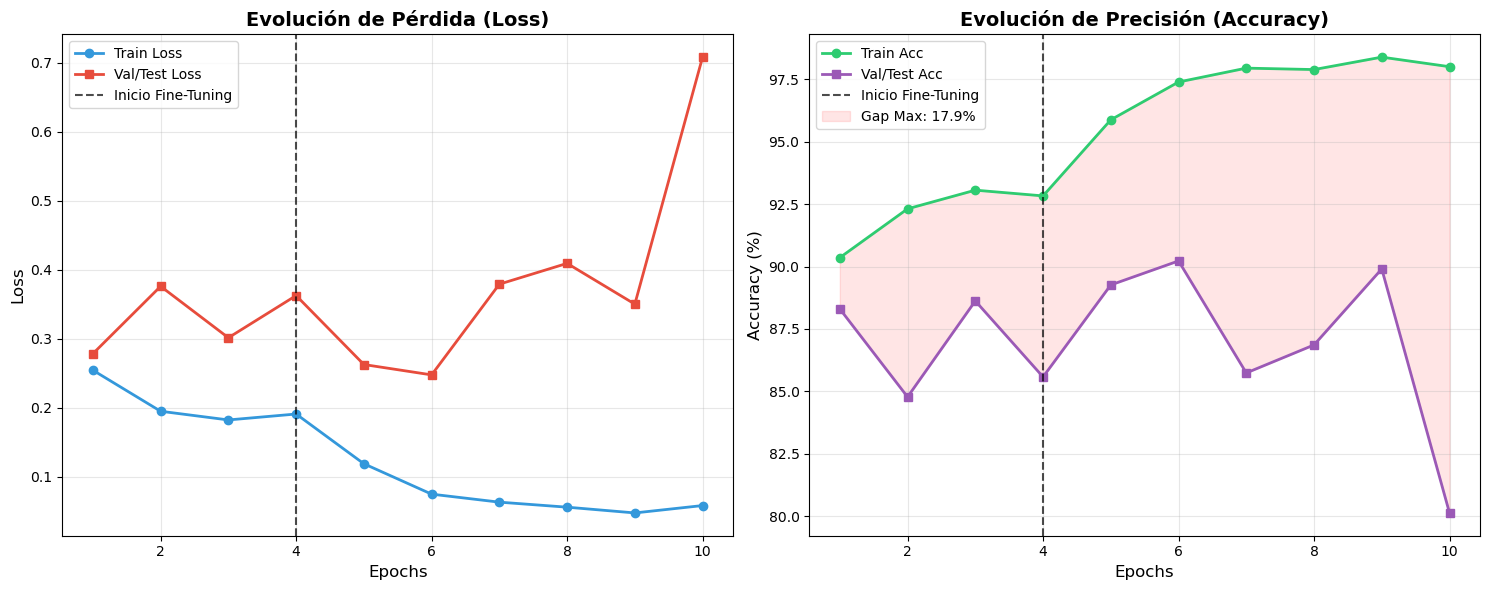

Generando gráficas de evaluación...


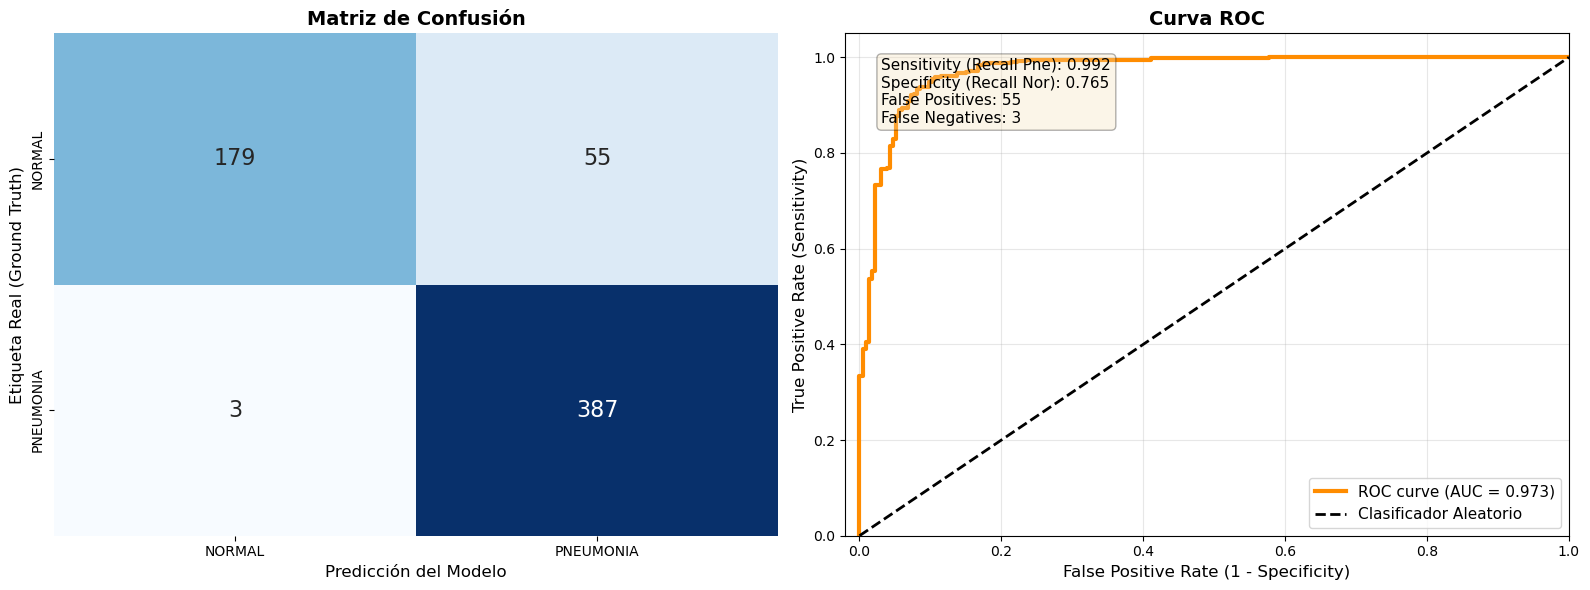


📊 Resumen de Métricas Clínicas:
  ➢ Sensitivity: 0.9923
  ➢ Specificity: 0.7650
  ➢ AUC-ROC:     0.9726

✅ Visualización completada.
📁 Las imágenes se guardaron en: /Users/liroly0_0/ChestXRay_Pneumonia_Detection/ChestXRay_Pneumonia_Detection/results/figures


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import os

# --- PREPARACIÓN DE DIRECTORIOS ---
# Esto evita errores si la carpeta no existe
os.makedirs('../results/figures', exist_ok=True)

def plot_training_curves(history_p1, history_p2):
    """
    Grafica curvas de entrenamiento combinando Fase 1 (Feature Extraction)
    y Fase 2 (Fine-Tuning).
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Combinar historias de las dos fases
    # history_p1 = history_fe (Feature Extraction)
    # history_p2 = history_ft (Fine Tuning)
    
    epochs_p1 = len(history_p1['train_loss'])
    epochs_p2 = len(history_p2['train_loss'])
    
    # El eje X será continuo (ej: epoch 1 a 25)
    total_epochs_range = list(range(1, epochs_p1 + epochs_p2 + 1))
    
    # Concatenar listas de métricas
    train_loss = history_p1['train_loss'] + history_p2['train_loss']
    test_loss = history_p1['test_loss'] + history_p2['test_loss']
    train_acc = history_p1['train_acc'] + history_p2['train_acc']
    test_acc = history_p1['test_acc'] + history_p2['test_acc']
    
    # --- GRÁFICA 1: LOSS ---
    axes[0].plot(total_epochs_range, train_loss, 'o-', label='Train Loss', linewidth=2, color='#3498db')
    axes[0].plot(total_epochs_range, test_loss, 's-', label='Val/Test Loss', linewidth=2, color='#e74c3c')
    
    # Línea vertical para marcar el inicio del Fine-Tuning
    axes[0].axvline(x=epochs_p1, color='black', linestyle='--', alpha=0.7, label='Inicio Fine-Tuning')
    
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Evolución de Pérdida (Loss)', fontsize=14, weight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # --- GRÁFICA 2: ACCURACY ---
    axes[1].plot(total_epochs_range, train_acc, 'o-', label='Train Acc', linewidth=2, color='#2ecc71')
    axes[1].plot(total_epochs_range, test_acc, 's-', label='Val/Test Acc', linewidth=2, color='#9b59b6')
    
    # Línea vertical para Fine-Tuning
    axes[1].axvline(x=epochs_p1, color='black', linestyle='--', alpha=0.7, label='Inicio Fine-Tuning')
    
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Evolución de Precisión (Accuracy)', fontsize=14, weight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Detectar y resaltar zona de Overfitting si la brecha es grande (>10%)
    max_gap = max([t - te for t, te in zip(train_acc, test_acc)])
    if max_gap > 10:
        axes[1].fill_between(total_epochs_range, train_acc, test_acc, 
                            alpha=0.1, color='red', 
                            label=f'Gap Max: {max_gap:.1f}%')
        axes[1].legend(fontsize=10)
    
    plt.tight_layout()
    # Guardar gráfica
    plt.savefig('../results/figures/resnet_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_and_roc(labels, preds, probs):
    """
    Genera Matriz de Confusión y Curva ROC basadas en las predicciones del test set.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- MATRIZ DE CONFUSIÓN ---
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'],
                ax=axes[0], annot_kws={"size": 16}, cbar=False)
    
    axes[0].set_title('Matriz de Confusión', fontsize=14, weight='bold')
    axes[0].set_ylabel('Etiqueta Real (Ground Truth)', fontsize=12)
    axes[0].set_xlabel('Predicción del Modelo', fontsize=12)
    
    # Calcular métricas clínicas dentro de la función para mostrar en gráfico
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall PNEUMONIA
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Recall NORMAL
    
    # --- CURVA ROC ---
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    axes[1].plot(fpr, tpr, linewidth=3, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador Aleatorio')
    
    axes[1].set_xlim([-0.02, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    axes[1].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    axes[1].set_title('Curva ROC', fontsize=14, weight='bold')
    axes[1].legend(loc="lower right", fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Cuadro de texto con métricas detalladas
    stats_text = (f"Sensitivity (Recall Pne): {sensitivity:.3f}\n"
                  f"Specificity (Recall Nor): {specificity:.3f}\n"
                  f"False Positives: {fp}\n"
                  f"False Negatives: {fn}")
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes, fontsize=11,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('../results/figures/resnet_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Imprimir resumen en consola
    print("\n📊 Resumen de Métricas Clínicas:")
    print(f"  ➢ Sensitivity: {sensitivity:.4f}")
    print(f"  ➢ Specificity: {specificity:.4f}")
    print(f"  ➢ AUC-ROC:     {roc_auc:.4f}")

# --- EJECUCIÓN ---

# 1. Graficar Curvas de Aprendizaje (Loss y Accuracy)
# Usamos las variables que retornó tu entrenamiento anterior: history_fe y history_ft
print("Generando curvas de entrenamiento...")
plot_training_curves(history_fe, history_ft)

# 2. Graficar Evaluación Final (Matriz y ROC)
# Usamos las variables que retornó tu evaluación: test_labels, test_preds, test_probs
print("Generando gráficas de evaluación...")
plot_confusion_matrix_and_roc(test_labels, test_preds, test_probs)

print("\n✅ Visualización completada.")
print(f"📁 Las imágenes se guardaron en: {os.path.abspath('../results/figures')}")

In [16]:
print("\n" + "="*60)
print("ANÁLISIS DE OVERFITTING")
print("="*60)

# CORRECCIÓN: Usamos 'history_ft' que es la variable de la Fase 2 que definimos antes
final_train_acc = history_ft['train_acc'][-1]
final_test_acc = history_ft['test_acc'][-1]
gap = final_train_acc - final_test_acc

print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy:  {final_test_acc:.2f}%")
print(f"Generalization Gap:   {gap:.2f}%")

# Lógica de semáforo para el diagnóstico
if gap < 5:
    print("✅ Excelente generalización. El modelo es robusto.")
elif gap < 10:
    print("✓ Buena generalización. Resultado aceptable para medicina.")
elif gap < 15:
    print("⚠️  Overfitting leve - El modelo memoriza un poco.")
else:
    print("❌ Overfitting severo - La brecha entre entrenamiento y validación es muy alta.")

print("\nRecomendaciones basadas en el Gap:")
if gap > 10:
    print("  1. Aumentar dropout (actual: 0.5 → probar 0.6 o 0.7)")
    print("  2. Agregar Weight Decay al optimizador (ej: weight_decay=1e-4)")
    print("  3. Early Stopping fue muy permisivo, reducir 'patience'")
    print("  4. Aumentar la agresividad de Data Augmentation (rotaciones, zoom)")
else:
    print("  - Mantener la configuración actual, es estable.")


ANÁLISIS DE OVERFITTING
Final Train Accuracy: 98.01%
Final Test Accuracy:  80.13%
Generalization Gap:   17.88%
❌ Overfitting severo - La brecha entre entrenamiento y validación es muy alta.

Recomendaciones basadas en el Gap:
  1. Aumentar dropout (actual: 0.5 → probar 0.6 o 0.7)
  2. Agregar Weight Decay al optimizador (ej: weight_decay=1e-4)
  3. Early Stopping fue muy permisivo, reducir 'patience'
  4. Aumentar la agresividad de Data Augmentation (rotaciones, zoom)
